In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Настройка стиля графиков
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

In [6]:
def load_ablation_data(base_path="./artifacts/ablation"):
    all_data = []
    
    # Ищем все папки в директории абляций
    experiments = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    
    for exp_name in sorted(experiments):
        csv_path = os.path.join(base_path, exp_name, "stats.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            # Добавляем колонку с названием эксперимента для легенды
            df['Experiment'] = exp_name
            # Сглаживание для графиков (Moving Average)
            df['smoothed_length'] = df['episode_length'].rolling(window=50, min_periods=5).mean()
            df['smoothed_reward'] = df['total_reward'].rolling(window=50, min_periods=5).mean()
            all_data.append(df)
            print(f"Loaded: {exp_name} ({len(df)} episodes)")
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

df_all = load_ablation_data()

Loaded: 0_baseline (40 episodes)
Loaded: 1_only_norm (40 episodes)
Loaded: 2_only_entropy (40 episodes)
Loaded: 3_only_relative_state (1 episodes)


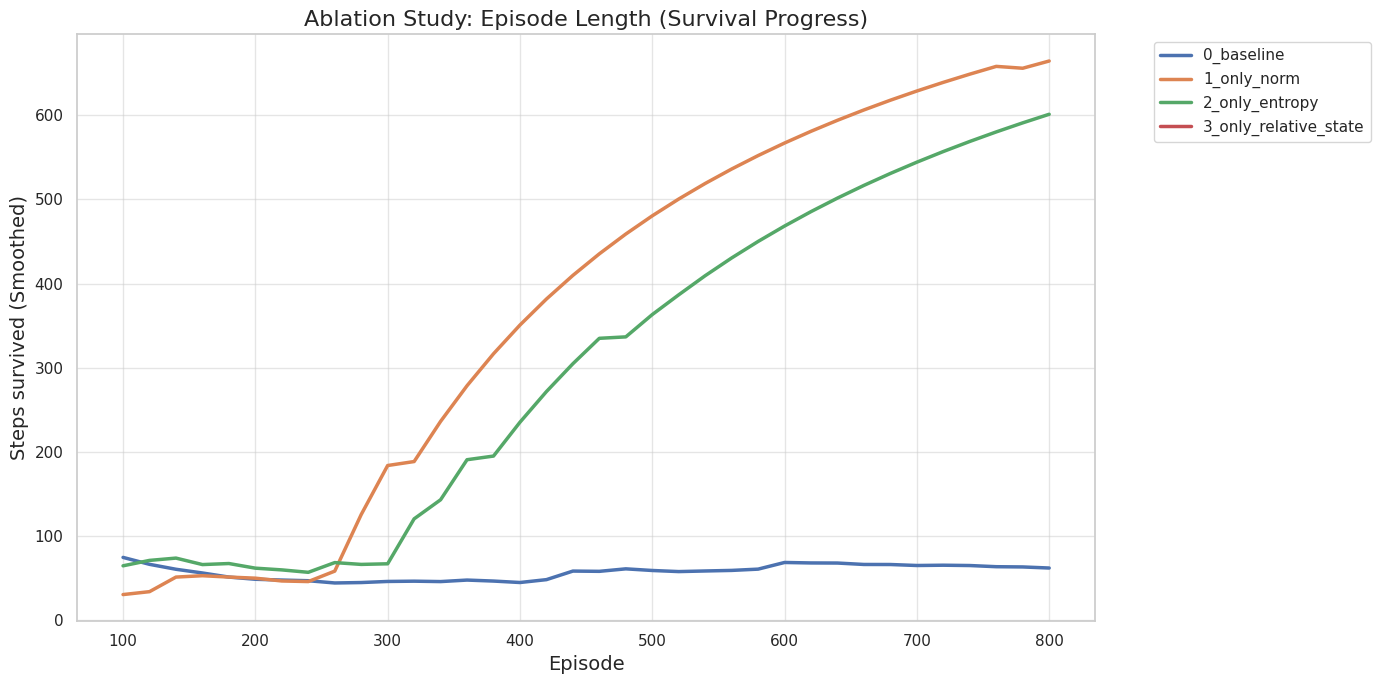

In [7]:
if not df_all.empty:
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_all, x="episode", y="smoothed_length", hue="Experiment", linewidth=2.5)
    
    plt.title("Ablation Study: Episode Length (Survival Progress)", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Steps survived (Smoothed)", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No data found. Run run_ablation.sh first!")

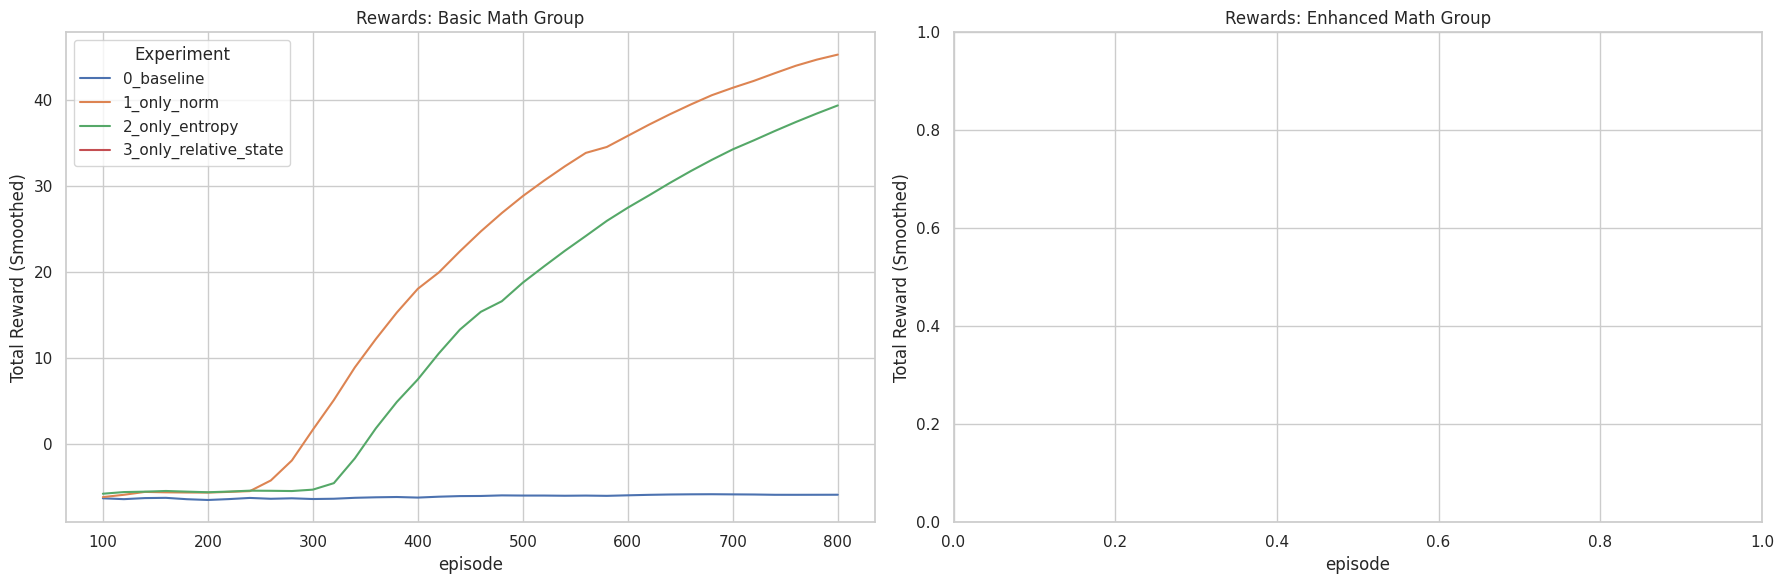

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Группа с базовыми наградами
basic_mask = df_all['Experiment'].str.contains('baseline|norm|entropy|relative_state')
df_basic = df_all[basic_mask]
sns.lineplot(data=df_basic, x="episode", y="smoothed_reward", hue="Experiment", ax=ax1)
ax1.set_title("Rewards: Basic Math Group")
ax1.set_ylabel("Total Reward (Smoothed)")

# Группа с усиленными наградами
enhanced_mask = df_all['Experiment'].str.contains('enhanced_reward|full_optimized')
df_enhanced = df_all[enhanced_mask]
sns.lineplot(data=df_enhanced, x="episode", y="smoothed_reward", hue="Experiment", ax=ax2)
ax2.set_title("Rewards: Enhanced Math Group")
ax2.set_ylabel("Total Reward (Smoothed)")

plt.tight_layout()
plt.show()

/tmp/ipykernel_470517/2148008646.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_stats, x="episode_length", y="Experiment", palette="viridis")


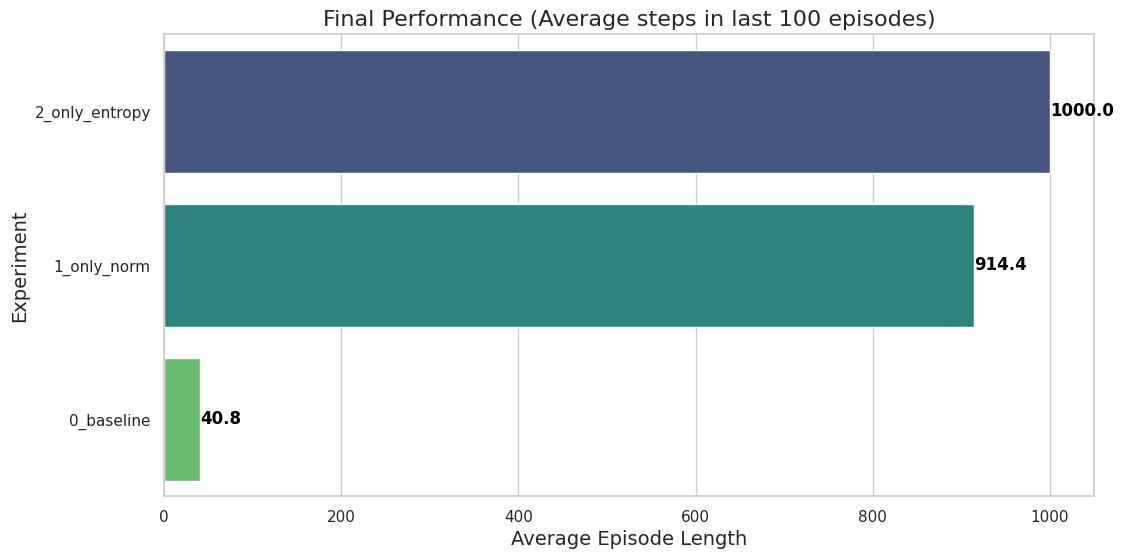

In [9]:
# Берем последние 100 эпизодов для каждого эксперимента
last_100 = df_all[df_all['episode'] > (df_all['episode'].max() - 100)]
final_stats = last_100.groupby('Experiment')['episode_length'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=final_stats, x="episode_length", y="Experiment", palette="viridis")

plt.title("Final Performance (Average steps in last 100 episodes)", fontsize=16)
plt.xlabel("Average Episode Length", fontsize=14)
plt.ylabel("Experiment", fontsize=14)

# Добавляем значения на бары
for i, v in enumerate(final_stats['episode_length']):
    plt.text(v + 0.5, i, f"{v:.1f}", color='black', va='center', fontweight='bold')

plt.show()